# CLASSIFICATION PROJECT

## Dataset: Loan Approval

## DATA PREPROCESSING

### Importing Libraries

In [510]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

### Reading Data

In [513]:
df = pd.read_csv('la.csv')

### Exporing Data

In [516]:
df.head()

,ApplicantIncome,LoanAmount,CreditScore,EmploymentStatus,MaritalStatus,LoanTermMonths,Dependents,Education,LoanStatus
0,9270,565,664,Unemployed,Married,36.0,2.0,Not Graduate,1
1,2860,703,625,Employed,Married,60.0,0.0,Not Graduate,0
2,7390,781,766,Self-employed,Married,60.0,2.0,Graduate,1
3,7191,928,713,Unemployed,Single,12.0,3.0,Not Graduate,1
4,13964,633,754,Unemployed,Married,48.0,2.0,Graduate,1


In [517]:
df.tail()

,ApplicantIncome,LoanAmount,CreditScore,EmploymentStatus,MaritalStatus,LoanTermMonths,Dependents,Education,LoanStatus
995,8777,459,526,Employed,Single,24.0,1.0,Not Graduate,1
996,13314,322,775,Employed,Single,48.0,3.0,Not Graduate,1
997,9570,965,776,Unemployed,Single,48.0,0.0,Graduate,1
998,9956,799,564,Employed,Married,48.0,3.0,Graduate,1
999,7124,547,671,Self-employed,Single,48.0,4.0,Not Graduate,1


In [520]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ApplicantIncome   1000 non-null   int64  
 1   LoanAmount        1000 non-null   int64  
 2   CreditScore       1000 non-null   int64  
 3   EmploymentStatus  1000 non-null   object 
 4   MaritalStatus     1000 non-null   object 
 5   LoanTermMonths    999 non-null    float64
 6   Dependents        998 non-null    float64
 7   Education         1000 non-null   object 
 8   LoanStatus        1000 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 70.4+ KB


In [522]:
df.describe()

,ApplicantIncome,LoanAmount,CreditScore,LoanTermMonths,Dependents,LoanStatus
count,1000.000000,1000.000000,1000.000000,999.000000,998.000000,1000.00000
mean,8614.667000,539.348000,576.627000,36.540541,1.957916,0.87900
std,3967.811171,264.910442,158.216612,16.683188,1.428409,0.32629
min,2004.000000,100.000000,300.000000,12.000000,0.000000,0.00000
25%,5501.000000,315.000000,441.750000,24.000000,1.000000,1.00000
50%,8616.500000,534.000000,577.500000,36.000000,2.000000,1.00000
75%,11730.750000,769.000000,712.250000,48.000000,3.000000,1.00000
max,57578.000000,998.000000,849.000000,60.000000,4.000000,1.00000


### Cleansing Data

#### Before Cleansing Data

In [526]:
df.isnull().sum()

ApplicantIncome     0
LoanAmount          0
CreditScore         0
EmploymentStatus    0
MaritalStatus       0
LoanTermMonths      1
Dependents          2
Education           0
LoanStatus          0
dtype: int64

#### After Cleansing Data

##### Handle missing values in numeric columns (fill with median)

In [529]:
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

##### Handle missing values in categorical columns (fill with mode)

In [533]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [535]:
df.isnull().sum()

ApplicantIncome     0
LoanAmount          0
CreditScore         0
EmploymentStatus    0
MaritalStatus       0
LoanTermMonths      0
Dependents          0
Education           0
LoanStatus          0
dtype: int64

### Outlier Detection and Removal

Original class counts:
LoanStatus
1    879
0    121
Name: count, dtype: int64

Cleaned class counts:
LoanStatus
1    878
0    121
Name: count, dtype: int64

Rows removed: 1
Final shape of cleaned dataset: (999, 9)


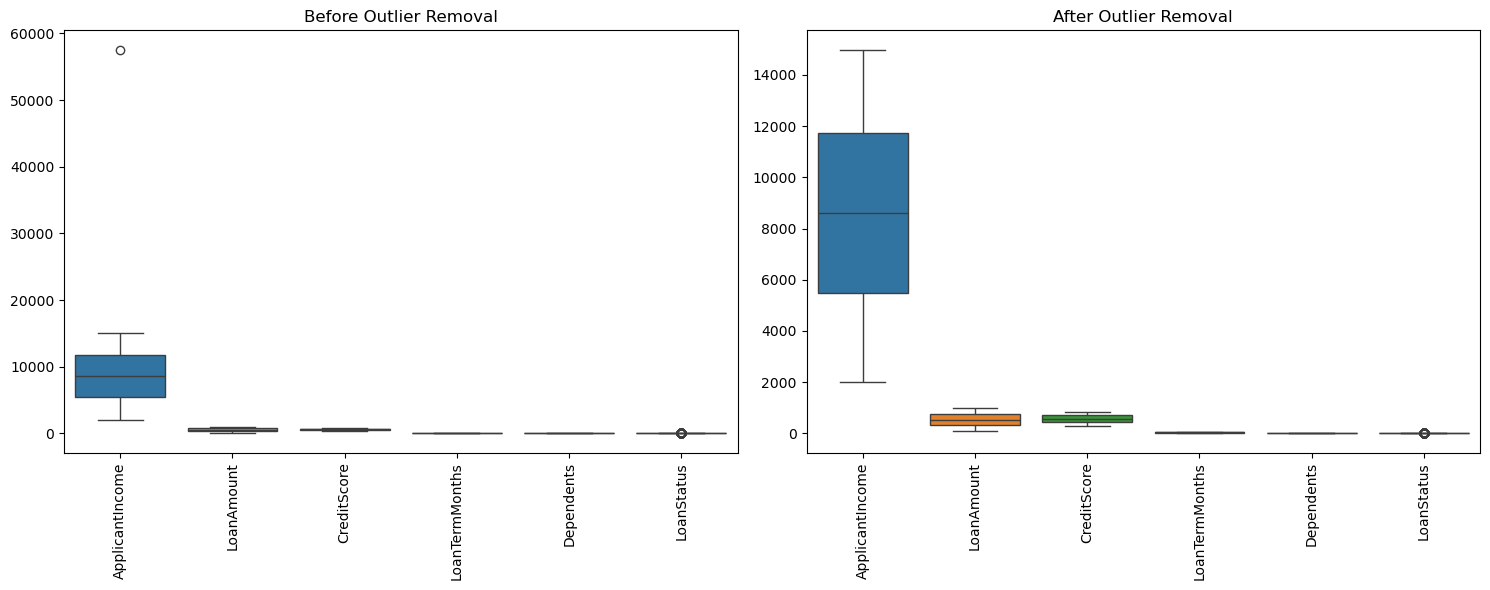

In [538]:
df_class_1 = df[df['LoanStatus'] == 1]
df_class_0 = df[df['LoanStatus'] == 0]

def remove_outliers_iqr(df_subset):
    numeric_cols = df_subset.select_dtypes(include=[np.number]).columns
    Q1 = df_subset[numeric_cols].quantile(0.25)
    Q3 = df_subset[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    mask = ~((df_subset[numeric_cols] < (Q1 - 1.5 * IQR)) | 
             (df_subset[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)
    return df_subset[mask]

df_class_1_clean = remove_outliers_iqr(df_class_1.drop(columns=['LoanStatus']))
df_class_0_clean = remove_outliers_iqr(df_class_0.drop(columns=['LoanStatus']))

df_class_1_clean['LoanStatus'] = 1
df_class_0_clean['LoanStatus'] = 0

df_cleaned = pd.concat([df_class_1_clean, df_class_0_clean], axis=0).reset_index(drop=True)

print(f"Original class counts:\n{df['LoanStatus'].value_counts()}")
print(f"\nCleaned class counts:\n{df_cleaned['LoanStatus'].value_counts()}")
print(f"\nRows removed: {len(df) - len(df_cleaned)}")
print(f"Final shape of cleaned dataset: {df_cleaned.shape}")

numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(data=df[numeric_cols])
plt.title('Before Outlier Removal')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.boxplot(data=df_cleaned[numeric_cols])
plt.title('After Outlier Removal')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### Separate Target Column

In [540]:
X = df_cleaned.drop('LoanStatus', axis=1) 
y = df_cleaned['LoanStatus']

### Data Transformation (Standardization)

#### Before Standardization

In [543]:
X.head()

,ApplicantIncome,LoanAmount,CreditScore,EmploymentStatus,MaritalStatus,LoanTermMonths,Dependents,Education
0,9270,565,664,Unemployed,Married,36.0,2.0,Not Graduate
1,7390,781,766,Self-employed,Married,60.0,2.0,Graduate
2,7191,928,713,Unemployed,Single,12.0,3.0,Not Graduate
3,13964,633,754,Unemployed,Married,48.0,2.0,Graduate
4,13284,504,532,Self-employed,Married,12.0,3.0,Not Graduate


#### After Standardization

In [547]:
numeric_cols = X.select_dtypes(include=np.number).columns

X[numeric_cols] = X[numeric_cols].astype(float)

scaler = StandardScaler()
X.loc[:, numeric_cols] = scaler.fit_transform(X[numeric_cols])

X.head()

,ApplicantIncome,LoanAmount,CreditScore,EmploymentStatus,MaritalStatus,LoanTermMonths,Dependents,Education
0,0.192835,0.097154,0.551353,Unemployed,Married,-0.031007,0.029462,Not Graduate
1,-0.321870,0.912564,1.196788,Self-employed,Married,1.409717,0.029462,Graduate
2,-0.376352,1.467497,0.861415,Unemployed,Single,-1.471730,0.730243,Not Graduate
3,1.477955,0.353857,1.120854,Unemployed,Married,0.689355,0.029462,Graduate
4,1.291785,-0.133124,-0.283914,Self-employed,Married,-1.471730,0.730243,Not Graduate


### Categorical into Numerical (One-Hot Encoding)

#### Before One-Hot Encoding

In [552]:
X.shape

(999, 8)

In [554]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ApplicantIncome   999 non-null    float64
 1   LoanAmount        999 non-null    float64
 2   CreditScore       999 non-null    float64
 3   EmploymentStatus  999 non-null    object 
 4   MaritalStatus     999 non-null    object 
 5   LoanTermMonths    999 non-null    float64
 6   Dependents        999 non-null    float64
 7   Education         999 non-null    object 
dtypes: float64(5), object(3)
memory usage: 62.6+ KB


#### After One-Hot Encoding

In [557]:
X = pd.get_dummies(X, drop_first=False)

In [559]:
X.shape

(999, 12)

In [561]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ApplicantIncome                 999 non-null    float64
 1   LoanAmount                      999 non-null    float64
 2   CreditScore                     999 non-null    float64
 3   LoanTermMonths                  999 non-null    float64
 4   Dependents                      999 non-null    float64
 5   EmploymentStatus_Employed       999 non-null    bool   
 6   EmploymentStatus_Self-employed  999 non-null    bool   
 7   EmploymentStatus_Unemployed     999 non-null    bool   
 8   MaritalStatus_Married           999 non-null    bool   
 9   MaritalStatus_Single            999 non-null    bool   
 10  Education_Graduate              999 non-null    bool   
 11  Education_Not Graduate          999 non-null    bool   
dtypes: bool(7), float64(5)
memory usage:

### Handle Imbalanced Data

#### Before Handling Imbalanced Data

In [565]:
y.value_counts()

LoanStatus
1    878
0    121
Name: count, dtype: int64

#### After Handling Imbalanced Data

In [568]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [570]:
print(X.shape)
print(y.shape)
y.value_counts()

(1756, 12)
(1756,)


LoanStatus
1    878
0    878
Name: count, dtype: int64

### Feature Selection

In [573]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)

Selected features: Index(['ApplicantIncome', 'LoanAmount', 'CreditScore',
       'EmploymentStatus_Employed', 'EmploymentStatus_Unemployed',
       'MaritalStatus_Single'],
      dtype='object')


### Data Splitting

In [576]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1404, 6), (352, 6), (1404,), (352,))

## CLASSIFICATION

### a. Random Forest

#### Train the model

In [581]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

#### Classification Report

In [583]:
y_pred_rf = rf.predict(X_test)
print("\nRandom Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest
Accuracy: 0.9857954545454546
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       169
           1       1.00      0.97      0.99       183

    accuracy                           0.99       352
   macro avg       0.99      0.99      0.99       352
weighted avg       0.99      0.99      0.99       352

Confusion Matrix:
 [[169   0]
 [  5 178]]


#### Confusion Matrix

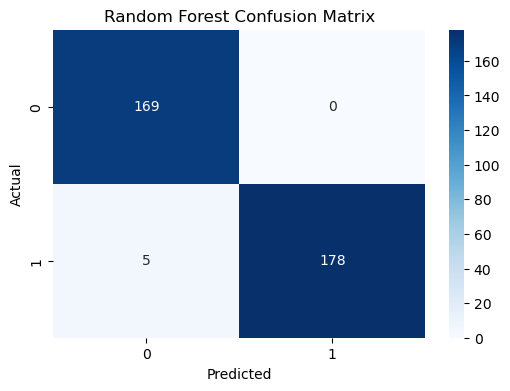

In [587]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### b. SVM

#### Train the model

In [590]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)

SVC(probability=True)

#### Classification Report

In [593]:
y_pred_svm = svm.predict(X_test)
print("\nSVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


SVM
Accuracy: 0.9829545454545454
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       169
           1       1.00      0.97      0.98       183

    accuracy                           0.98       352
   macro avg       0.98      0.98      0.98       352
weighted avg       0.98      0.98      0.98       352

Confusion Matrix:
 [[169   0]
 [  6 177]]


#### Confusion Matrix

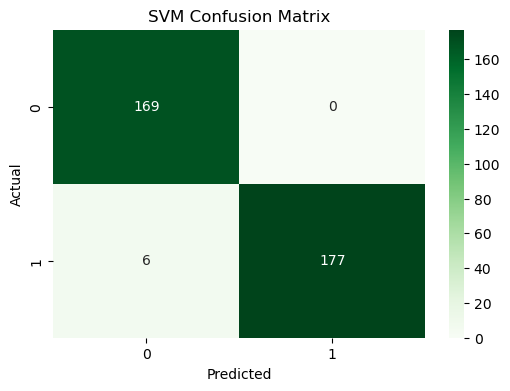

In [597]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### c. ANN

#### Train the model

In [601]:
ann = Sequential()
ann.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
ann.add(Dense(16, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)
ann_preds = (ann.predict(X_test) > 0.5).astype(int)

Epoch 1/50


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6163 - loss: 0.6554 
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9227 - loss: 0.4209 
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9438 - loss: 0.2400 
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9583 - loss: 0.1522 
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9697 - loss: 0.1230 
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9713 - loss: 0.0932 
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9757 - loss: 0.0784 
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9811 - loss: 0.0683 
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9765 - loss: 0.0712 
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9783 - loss: 0.0671 
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9814 - loss: 0.0610 
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9869 - lo

#### Classification Report

In [603]:
print("\nANN")
print("Accuracy:", accuracy_score(y_test, ann_preds))
print("Classification Report:\n", classification_report(y_test, ann_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, ann_preds))


ANN
Accuracy: 0.9943181818181818
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       169
           1       1.00      0.99      0.99       183

    accuracy                           0.99       352
   macro avg       0.99      0.99      0.99       352
weighted avg       0.99      0.99      0.99       352

Confusion Matrix:
 [[169   0]
 [  2 181]]


#### Confusion Matrix

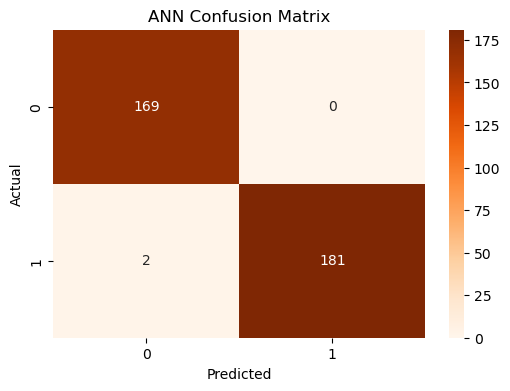

In [605]:
cm_ann = confusion_matrix(y_test, ann_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Oranges')
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Performance Analysis and Model Insights (Random Forest)

#### ROC Curve

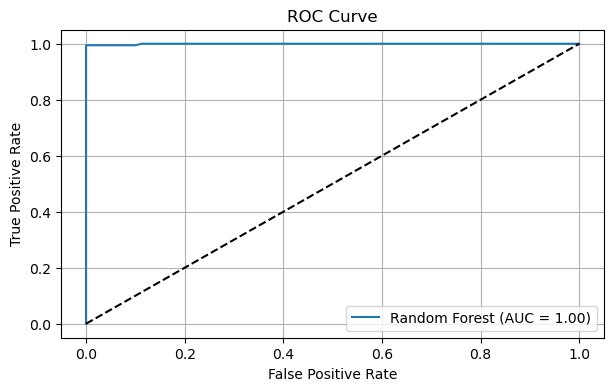

In [608]:
y_prob_rf = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

In [609]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier()

scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
print("AUC scores from cross-validation:", scores)
print("Mean AUC:", scores.mean())

AUC scores from cross-validation: [0.99927363 0.99917208 0.99709416 0.99970779 0.99980519]
Mean AUC: 0.9990105703955136


#### Learning Curve

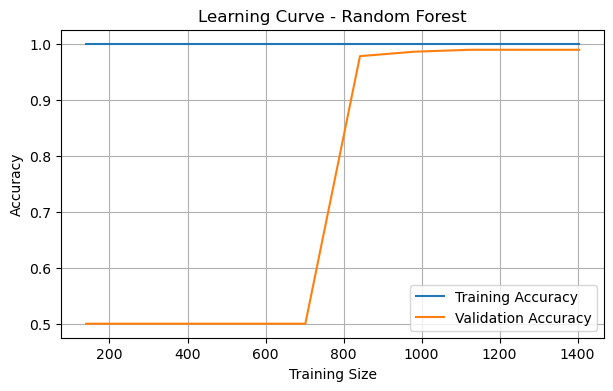

In [611]:
train_sizes, train_scores, test_scores = learning_curve(
    rf, X[selected_features], y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(7,4))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, test_mean, label='Validation Accuracy')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Random Forest')
plt.legend()
plt.grid()
plt.show()

#### Feature Importance

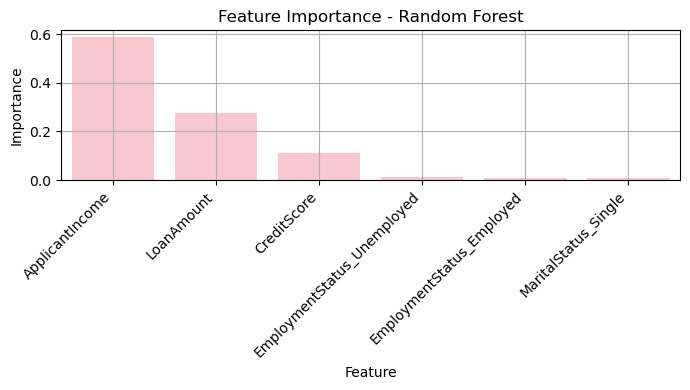

In [613]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features_sorted = [selected_features[i] for i in indices]
importances_sorted = importances[indices]

plt.figure(figsize=(7, 4))
sns.barplot(x=features_sorted, y=importances_sorted,  color='pink')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.tight_layout()
plt.show()